In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('csv_out')
# 加载CSV文件
df = pd.read_csv(path/'tracking_data.csv')

# 按照车辆ID和时间排序
df.sort_values(by=['id', 'frame'], inplace=True)

In [3]:
df.head()

frame      time  id class  center_x  center_y  speed_kmh
0       1  0.034483   1   car       385       281        NaN
25      2  0.068966   1   car       385       281        NaN
49      3  0.103448   1   car       385       281        NaN
73      4  0.137931   1   car       385       281        NaN
97      5  0.172414   1   car       385       281        NaN

In [4]:
df =  df.groupby('id').apply(lambda x: x.iloc[::30]).reset_index(drop=True)

In [5]:

def get_tra_from_id(df, vehicle_id):
    return df[df['id'] == vehicle_id]

def plot_turning_per_sec(df, vehicle_id, deg_thresh=10):
    df['center_y_inverted'] = df['center_y'] * -1
    
    
    # 计算每个车辆在每个时间点的位移
    df.loc[:, 'delta_x'] = df.groupby('id')['center_x'].diff()
    df.loc[:, 'delta_y'] = df.groupby('id')['center_y_inverted'].diff()
    
    # 计算每个点的方向角（弧度），范围为 [-π, π]
    df.loc[:, 'theta'] = np.arctan2(df['delta_y'], df['delta_x'])

    # 计算方向角的变化量（角速度）
    df.loc[:, 'delta_theta'] = df.groupby('id')['theta'].diff()
    
    # 为了处理角度跳变的问题，将变化量限制在 [-π, π] 范围内
    df.loc[:, 'delta_theta'] = (df['delta_theta'] + np.pi) % (2 * np.pi) - np.pi
    
    # 填充缺失值
    df.loc[:, 'delta_theta'] = df['delta_theta'].fillna(0)
    
    # 设置角度变化累积的窗口大小，例如3秒（假设帧率为30帧/秒）
    window_size = 2  # 2秒 
    
    # 对角度变化进行累积和
    df.loc[:, 'cum_delta_theta'] = df.groupby('id')['delta_theta'].rolling(window_size).sum().reset_index(level=0, drop=True)
    
    # 设置窗口大小（可以根据需要调整）
    
    
    # 使用滑动窗口来计算累积方向变化
    df.loc[:, 'windowed_delta_theta'] = df['delta_theta'].rolling(window=window_size, min_periods=1).sum()
    
    # 设置阈值来判断转弯方向
    turn_threshold = np.deg2rad(deg_thresh)  # 15度的阈值
    
    # 初始化转弯标签
    df['turn_label'] = 'Forward'  # 默认为直行
    
    # 计算像素上的移动距离
    df['distance_moved'] = np.sqrt(df['delta_x'] ** 2 + df['delta_y'] ** 2)
    
    # 将像素转换为米，1个像素对应 3.5/19 米
    df['distance_moved_meters'] = df['distance_moved'] * (3.5 / 19)
    
    # 设置移动距离的阈值，低于该阈值表示车辆没有实际移动
    movement_threshold = 0.5  # 阈值设为0.5米（可以根据实际情况调整）
    
    # 判断左转，仅当车辆实际移动的距离超过阈值时才标记为转弯
    df.loc[(df['windowed_delta_theta'] > turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'Turn Left'
    
    # 判断右转
    df.loc[(df['windowed_delta_theta'] < -turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'Turn Right'
    
    # 定义颜色映射，给 left_turn 和 right_turn 分配鲜艳的颜色
    color_map = {
        'Turn Left': 'red',
        'Turn Right': 'pink',
        'Forward': 'yellow'
    }
    
    # 获取车辆轨迹数据
    # vehicle_df = get_tra_from_id(df, vehicle_id)
    vehicle_df = df
    
    plt.figure(figsize=(10, 8))
    
    # 绘制轨迹
    plt.plot(vehicle_df['center_x'], vehicle_df['center_y'], 'b.-', label='Trajectory')
    
    # 根据转弯标签改变颜色
    for label, group in vehicle_df.groupby('turn_label'):
        plt.plot(group['center_x'], group['center_y'], '.', label=label, color=color_map.get(label, 'gray'))
    
    plt.gca().invert_yaxis()  # 反转 y 轴以匹配 OpenCV 的坐标系
    plt.legend()
    plt.xlabel('Center x')
    plt.ylabel('Center y')
    # plt.title(f'vehicle {vehicle_id} trajectory and turning label at each time')
    return df
    
    # plt.show() 

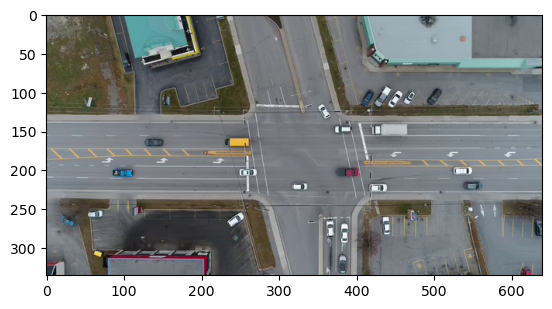

In [6]:
def plot_background_img():
    
    # 读取视频的第一帧
    video_path = 'one_video/DJI_0007.mp4'  # 将 'your_video.mp4' 替换为你的实际文件名
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    
    if ret:
        # 将 BGR 图像转换为 RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 在 Matplotlib 中显示图像
        plt.imshow(frame_rgb)
        
        # 绘制 scatter plot 叠加在图像上
        # plt.scatter(df['center_x'], df['center_y'], color='pink', s=0.5)
        
        
        plt.axis('on')  # 如果你不想显示坐标轴
        plt.savefig('background.png', dpi=300)
                
        # plt.savefig(f'background.jpeg', dpi=300)
        # plt.show()
        
    else:
        print("cannot read video, pls cheack video dir")

plot_background_img()

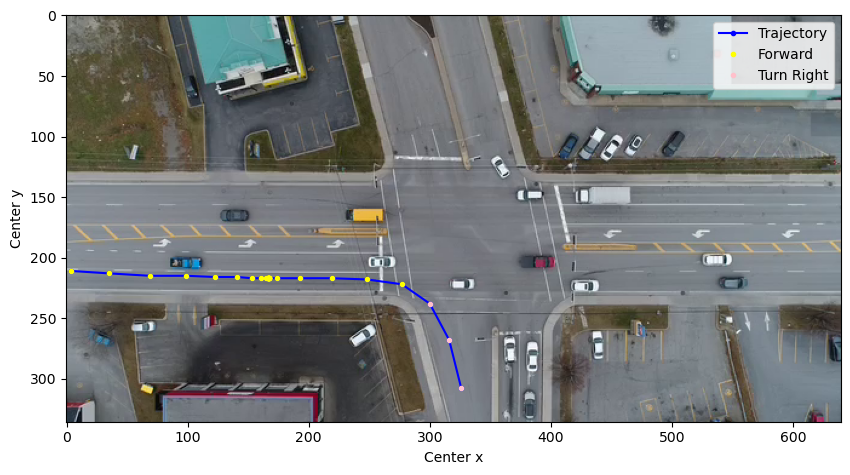

In [7]:
# vehicle_id = 50
vehicle_id = np.random.choice([50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390])


target_df = get_tra_from_id(df, vehicle_id)

turning_target_df = plot_turning_per_sec(target_df, vehicle_id)
plot_background_img()
plt.savefig(f'vehicle {vehicle_id} trajectory and turning label at each time', dpi=300)
plt.show()



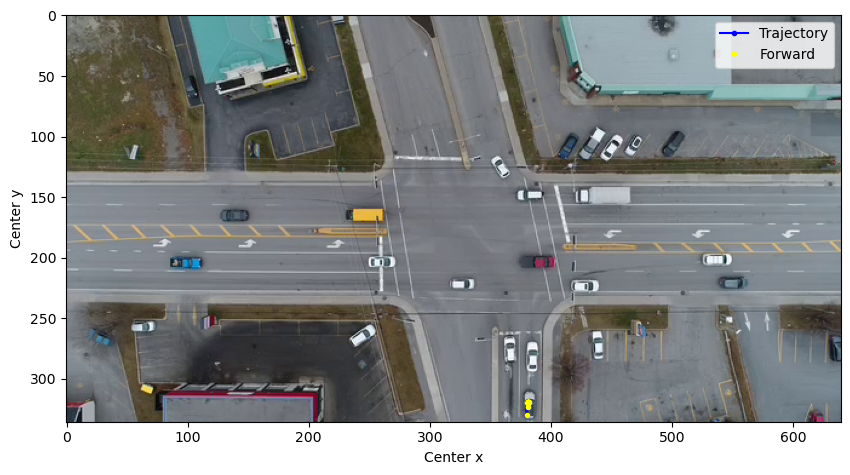

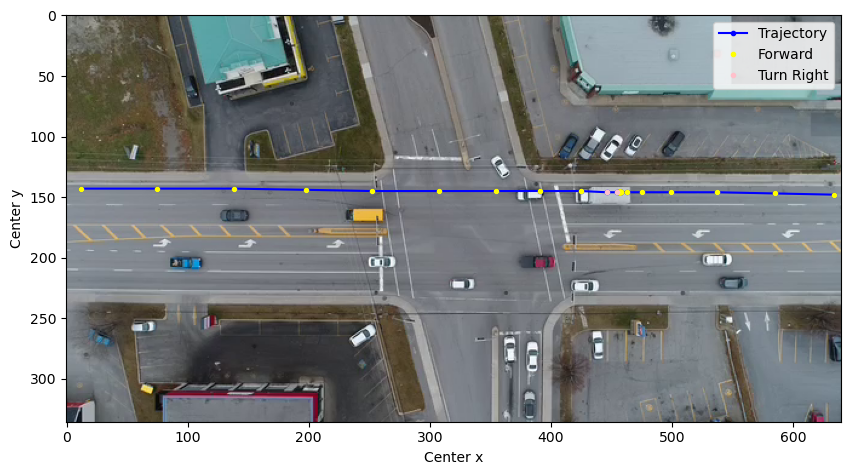

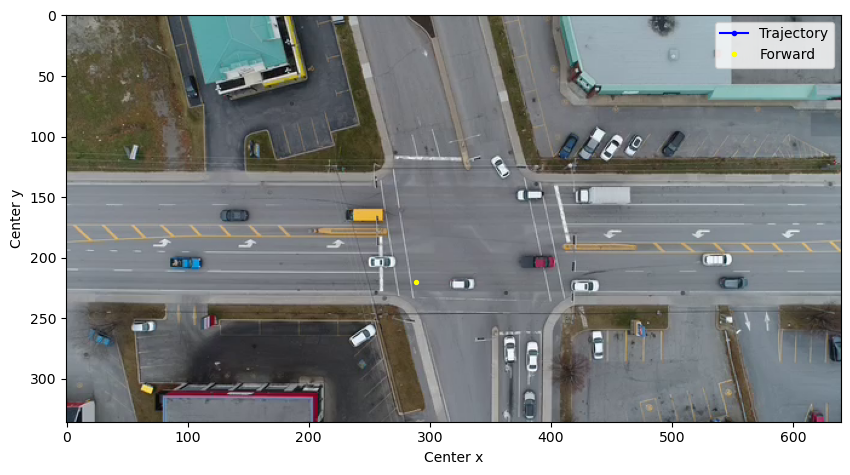

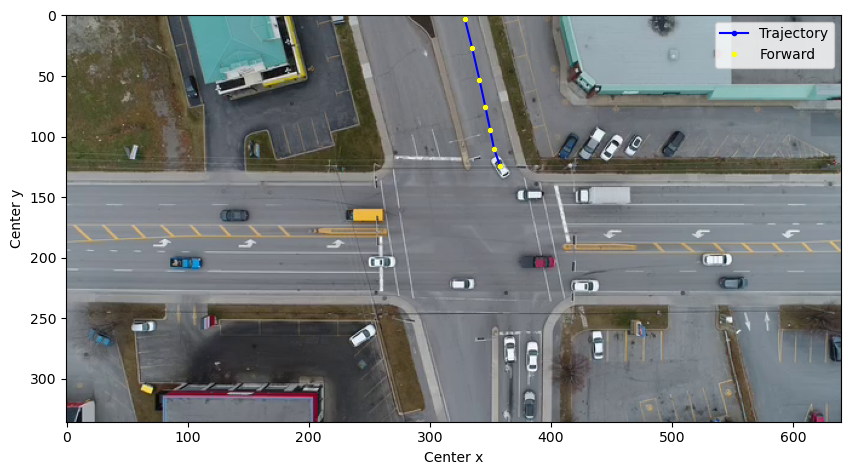

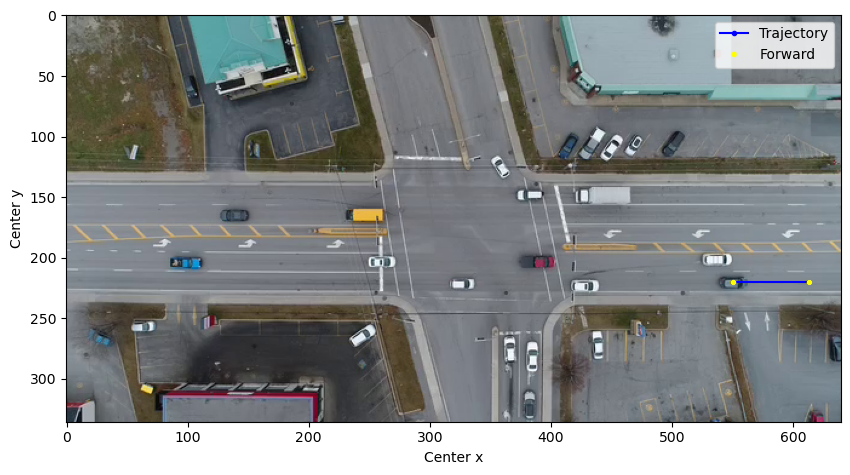

In [8]:
# 绘制5个不同车辆的轨迹图
for _ in range(5):
    
    vehicle_id = np.random.choice(df.id.unique())
    target_df = get_tra_from_id(df, vehicle_id)
    plot_turning_per_sec(target_df, vehicle_id)
    plot_background_img()

In [9]:
# 50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390

In [10]:
def refine_turning_label(df, vehicle_id, threshold=3):
    # 先对特定车辆的所有turn_label进行判断
    vehicle_df = df[df['id'] == vehicle_id].copy()

    # 计算每种转弯标签的数量
    left_turn_count = (vehicle_df['turn_label'] == 'left_turn').sum()
    right_turn_count = (vehicle_df['turn_label'] == 'right_turn').sum()

    # 如果 left_turn 的数量大于阈值，整体标记为 left_turn
    if left_turn_count >= threshold:
        vehicle_df['overall_turn_label'] = 'left_turn'
    # 如果没有足够的 left_turn，但 right_turn 的数量大于阈值，整体标记为 right_turn
    elif right_turn_count >= threshold:
        vehicle_df['overall_turn_label'] = 'right_turn'
    # 否则保持为 straight
    else:
        vehicle_df['overall_turn_label'] = 'straight'

    return vehicle_df

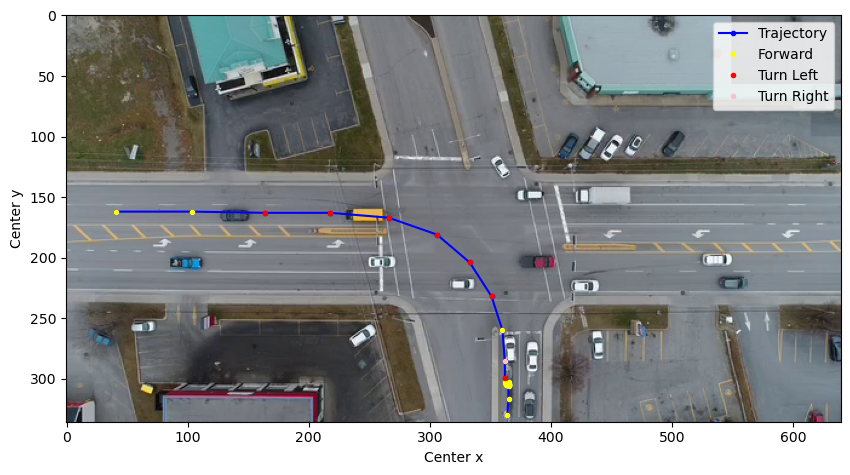

4581    straight
4582    straight
4583    straight
4584    straight
4585    straight
4586    straight
4587    straight
4588    straight
4589    straight
4590    straight
4591    straight
4592    straight
4593    straight
4594    straight
4595    straight
4596    straight
4597    straight
4598    straight
4599    straight
4600    straight
4601    straight
4602    straight
4603    straight
4604    straight
4605    straight
4606    straight
4607    straight
4608    straight
4609    straight
4610    straight
4611    straight
4612    straight
4613    straight
4614    straight
4615    straight
4616    straight
4617    straight
4618    straight
4619    straight
4620    straight
4621    straight
Name: overall_turn_label, dtype: object
turn_label
Forward       33
Turn Left      7
Turn Right     1
Name: count, dtype: int64


In [11]:
# vehicle_id = np.random.choice([50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390])
vehicle_id = 50
target_df = get_tra_from_id(df, vehicle_id)

turning_target_df = plot_turning_per_sec(target_df, vehicle_id)
plot_background_img()
plt.show()

# Example usage
refined_df = refine_turning_label(turning_target_df, vehicle_id)

print(refined_df['overall_turn_label'])

print(turning_target_df.turn_label.value_counts())


In [12]:
# 50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390

In [13]:
turning_target_df

frame       time  id class  center_x  center_y  speed_kmh  \
4581    427  14.724138  50   car       364       330  37.758413   
4582    457  15.758621  50   car       365       317   6.185745   
4583    487  16.793103  50   car       365       306   6.827324   
4584    517  17.827586  50   car       365       304   1.660909   
4585    547  18.862069  50   car       365       304   0.000000   
4586    577  19.896552  50   car       365       303   0.387545   
4587    607  20.931034  50   car       365       304   0.498273   
4588    637  21.965517  50   car       365       305   0.221455   
4589    667  23.000000  50   car       364       305   0.498273   
4590    697  24.034483  50   car       365       305   0.442909   
4591    727  25.068966  50   car       365       305   0.166091   
4592    757  26.103448  50   car       365       305   0.055364   
4593    787  27.137931  50   car       365       305   0.000000   
4594    817  28.172414  50   car       364       305   0.387545   
4595    847  29.206897  50   car       364       305   0.211956   
4596    877  30.241379  50   car       364       305   0.110727   
4597    907  31.275862  50   car       364       304   0.387545   
4598    937  32.310345  50   car       364       304   0.110727   
4599    967  33.344828  50   car       364       304   0.000000   
4600    997  34.379310  50   car       363       304   0.553636   
4601   1027  35.413793  50   car       363       305   0.387545   
4602   1057  36.448276  50   car       363       304   0.442909   
4603   1087  37.482759  50   car       363       304   0.000000   
4604   1117  38.517241  50   car       363       304   0.000000   
4605   1147  39.551724  50   car       363       304   0.000000   
4606   1177  40.586207  50   car       363       304   0.000000   
4607   1207  41.620690  50   car       363       304   0.000000   
4608   1237  42.655172  50   car       363       304   0.000000   
4609   1267  43.689655  50   car       363       304   0.000000   
4610   1297  44.724138  50   car       362       303   0.681732   
4611   1327  45.758621  50   car       362       299   1.700932   
4612   1357  46.793103  50   car       362       285   6.983144   
4613   1387  47.827586  50   car       360       260  12.526779   
4614   1417  48.862069  50   car       351       232  15.656632   
4615   1447  49.896552  50   car       333       204  17.328544   
4616   1477  50.931034  50   car       306       181  18.934870   
4617   1507  51.965517  50   car       266       167  22.088461   
4618   1537  53.000000  50   car       218       163  25.470969   
4619   1567  54.034483  50   car       164       163  28.733727   
4620   1597  55.068966  50   car       104       162  31.396065   
4621   1627  56.103448  50   car        41       162  33.495454   

      center_y_inverted  delta_x  delta_y     theta  delta_theta  \
4581               -330      NaN      NaN       NaN     0.000000   
4582               -317      1.0     13.0  1.494024     0.000000   
4583               -306      0.0     11.0  1.570796     0.076772   
4584               -304      0.0      2.0  1.570796     0.000000   
4585               -304      0.0      0.0  0.000000    -1.570796   
4586               -303      0.0      1.0  1.570796     1.570796   
4587               -304      0.0     -1.0 -1.570796    -3.141593   
4588               -305      0.0     -1.0 -1.570796     0.000000   
4589               -305     -1.0      0.0  3.141593    -1.570796   
4590               -305      1.0      0.0  0.000000    -3.141593   
4591               -305      0.0      0.0  0.000000     0.000000   
4592               -305      0.0      0.0  0.000000     0.000000   
4593               -305      0.0      0.0  0.000000     0.000000   
4594               -305     -1.0      0.0  3.141593    -3.141593   
4595               -305      0.0      0.0  0.000000    -3.141593   
4596               -305      0.0      0.0  0.000000     0.000000   
4597               -304      0.0   

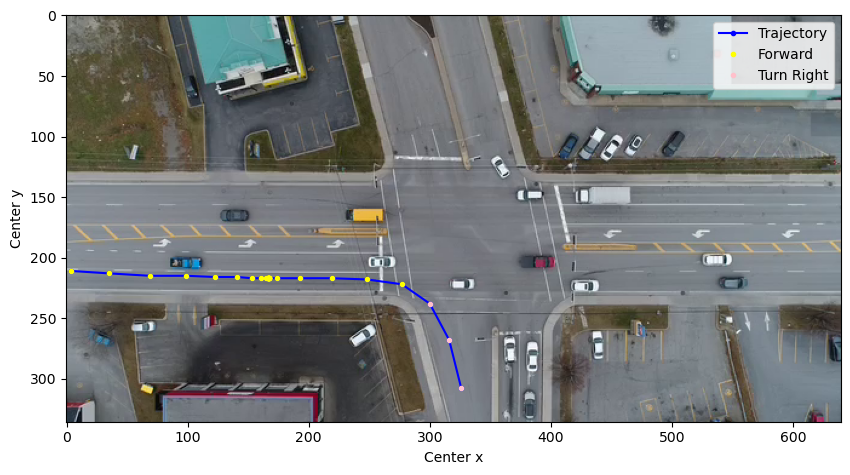

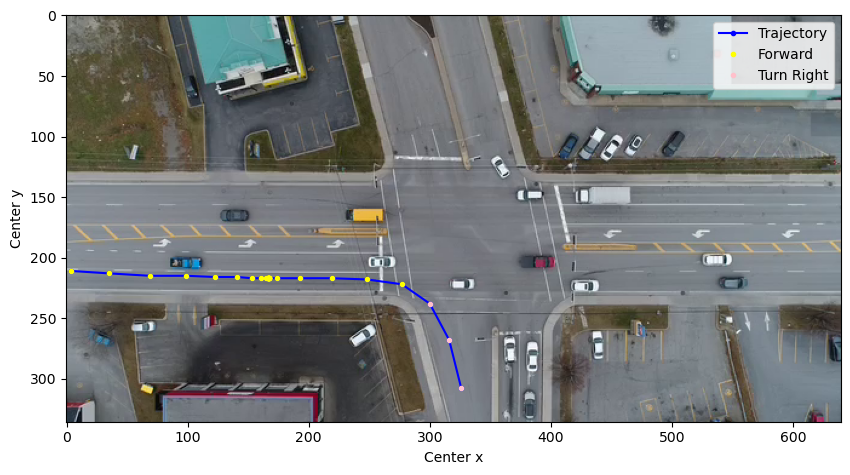

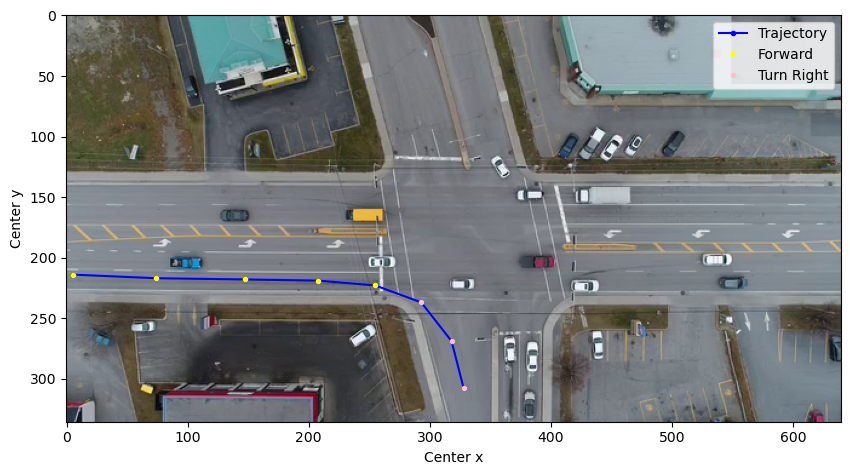

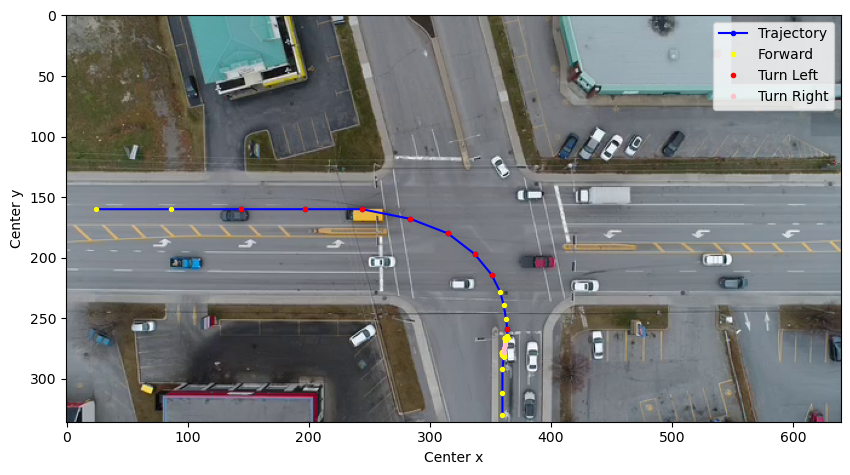

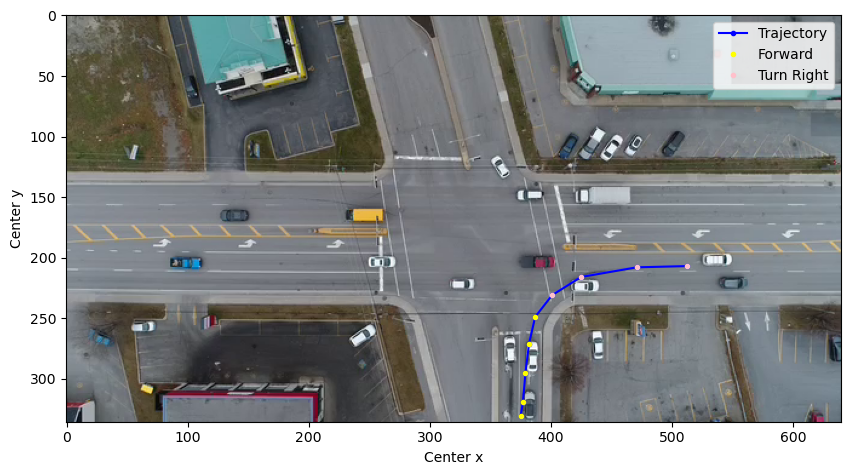

In [14]:
# 绘制5个不同车辆的轨迹图
for _ in range(5):
    
    vehicle_id = np.random.choice([50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390])
    target_df = get_tra_from_id(df, vehicle_id)
    plot_turning_per_sec(target_df, vehicle_id)
    plot_background_img()

In [15]:


def calc_turning_per_sec(df, vehicle_id, deg_thresh=10):
    df['center_y_inverted'] = df['center_y'] * -1
    
    
    # 计算每个车辆在每个时间点的位移
    df.loc[:, 'delta_x'] = df.groupby('id')['center_x'].diff()
    df.loc[:, 'delta_y'] = df.groupby('id')['center_y_inverted'].diff()
    
    # 计算每个点的方向角（弧度），范围为 [-π, π]
    df.loc[:, 'theta'] = np.arctan2(df['delta_y'], df['delta_x'])

    # 计算方向角的变化量（角速度）
    df.loc[:, 'delta_theta'] = df.groupby('id')['theta'].diff()
    
    # 为了处理角度跳变的问题，将变化量限制在 [-π, π] 范围内
    df.loc[:, 'delta_theta'] = (df['delta_theta'] + np.pi) % (2 * np.pi) - np.pi
    
    # 填充缺失值
    df.loc[:, 'delta_theta'] = df['delta_theta'].fillna(0)
    
    # 设置角度变化累积的窗口大小，例如3秒（假设帧率为30帧/秒）
    window_size = 2  # 2秒 
    
    # 对角度变化进行累积和
    df.loc[:, 'cum_delta_theta'] = df.groupby('id')['delta_theta'].rolling(window_size).sum().reset_index(level=0, drop=True)
    
    # 设置窗口大小（可以根据需要调整）
    
    
    # 使用滑动窗口来计算累积方向变化
    df.loc[:, 'windowed_delta_theta'] = df['delta_theta'].rolling(window=window_size, min_periods=1).sum()
    
    # 设置阈值来判断转弯方向
    turn_threshold = np.deg2rad(deg_thresh)  # 15度的阈值
    
    # 初始化转弯标签
    df['turn_label'] = 'straight'  # 默认为直行
    
    # 计算像素上的移动距离
    df['distance_moved'] = np.sqrt(df['delta_x'] ** 2 + df['delta_y'] ** 2)
    
    # 将像素转换为米，1个像素对应 3.5/19 米
    df['distance_moved_meters'] = df['distance_moved'] * (3.5 / 19)
    
    # 设置移动距离的阈值，低于该阈值表示车辆没有实际移动
    movement_threshold = 0.5  # 阈值设为0.5米（可以根据实际情况调整）
    
    # 判断左转，仅当车辆实际移动的距离超过阈值时才标记为转弯
    df.loc[(df['windowed_delta_theta'] > turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'left_turn'
    
    # 判断右转
    df.loc[(df['windowed_delta_theta'] < -turn_threshold) & (df['distance_moved_meters'] > movement_threshold), 'turn_label'] = 'right_turn'

    return df
    
    # plt.show() 

In [16]:
import numpy as np
import pandas as pd

def process_all_vehicle_ids_with_thresh(df, deg_thresh=10):
    all_refined_dfs = []
    for vehicle_id, group in df.groupby('id'):
        target_df = get_tra_from_id(df, vehicle_id)
        turning_target_df = calc_turning_per_sec(target_df, vehicle_id, deg_thresh=deg_thresh)
        refined_df = refine_turning_label(turning_target_df, vehicle_id)  # 你现有的投票/去抖
        all_refined_dfs.append(refined_df)
    final_df = pd.concat(all_refined_dfs, ignore_index=True)
    return final_df


def eval_lane_consistency(df_with_labels, lane_col='lane_type'):
    if lane_col not in df_with_labels.columns:
        return {}
    d = df_with_labels
    res = {}
    for lane in ['left', 'straight', 'right']:
        m = d[lane_col] == lane
        if m.any():
            res[f'{lane}_acc'] = (d.loc[m, 'turn_label'] == lane).mean()
    if res:
        res['overall'] = (d['turn_label'] == d[lane_col]).mean()
    return res

def sweep_thresholds(df, thresholds=(5,10,15)):
    rows = []
    for deg in thresholds:
        labeled = process_all_vehicle_ids_with_thresh(df, deg_thresh=deg)
        metrics = eval_lane_consistency(labeled, lane_col='lane_type')  # 需要你有这一列
        row = {'threshold_deg': deg}
        row.update(metrics)
        rows.append(row)
    return pd.DataFrame(rows)



In [17]:
def process_all_vehicle_ids(df):
    all_refined_dfs = []  # 用于存储所有处理后的数据
    
    # 按id分组
    for vehicle_id, group in df.groupby('id'):
        print(f"Processing vehicle_id: {vehicle_id}")
        
        # 获取当前车辆的数据
        target_df = get_tra_from_id(df, vehicle_id)
        
        # 计算转弯标签
        turning_target_df = calc_turning_per_sec(target_df, vehicle_id)
        
        # 应用 refine_turning_label 来生成精简后的转弯标签
        refined_df = refine_turning_label(turning_target_df, vehicle_id)
        
        # 将处理后的结果添加到列表中
        all_refined_dfs.append(refined_df)
    
    # 将所有处理后的数据框合并
    final_df = pd.concat(all_refined_dfs, ignore_index=True)
    
    return final_df


# Example usage:
final_df = process_all_vehicle_ids(df)

# 打印所有处理后的转弯标签统计
print(final_df['turn_label'].value_counts())

# 可以选择进一步的操作，比如保存或可视化

Processing vehicle_id: 1
Processing vehicle_id: 2
Processing vehicle_id: 3
Processing vehicle_id: 4
Processing vehicle_id: 5
Processing vehicle_id: 6
Processing vehicle_id: 7
Processing vehicle_id: 8
Processing vehicle_id: 9
Processing vehicle_id: 10
Processing vehicle_id: 11
Processing vehicle_id: 12
Processing vehicle_id: 13
Processing vehicle_id: 14
Processing vehicle_id: 15
Processing vehicle_id: 16
Processing vehicle_id: 17
Processing vehicle_id: 18
Processing vehicle_id: 19
Processing vehicle_id: 20
Processing vehicle_id: 21
Processing vehicle_id: 22
Processing vehicle_id: 23
Processing vehicle_id: 24
Processing vehicle_id: 25
Processing vehicle_id: 26
Processing vehicle_id: 27
Processing vehicle_id: 28
Processing vehicle_id: 29
Processing vehicle_id: 30
Processing vehicle_id: 32
Processing vehicle_id: 33
Processing vehicle_id: 34
Processing vehicle_id: 35
Processing vehicle_id: 36
Processing vehicle_id: 37
Processing vehicle_id: 38
Processing vehicle_id: 39
Processing vehicle_id

In [18]:
final_df.head()

frame      time  id class  center_x  center_y  speed_kmh  \
0      1  0.034483   1   car       385       281        NaN   
1     31  1.068966   1   car       385       282   0.055364   
2     61  2.103448   1   car       385       281   0.110727   
3     91  3.137931   1   car       385       281   0.000000   
4    121  4.172414   1   car       385       281   0.000000   

   center_y_inverted  delta_x  delta_y     theta  delta_theta  \
0               -281      NaN      NaN       NaN     0.000000   
1               -282      0.0     -1.0 -1.570796     0.000000   
2               -281      0.0      1.0  1.570796    -3.141593   
3               -281      0.0      0.0  0.000000    -1.570796   
4               -281      0.0      0.0  0.000000     0.000000   

   cum_delta_theta  windowed_delta_theta turn_label  distance_moved  \
0              NaN              0.000000   straight             NaN   
1         0.000000              0.000000   straight             1.0   
2        -3.141593             -3.141593   straight             1.0   
3        -4.712389             -4.712389   straight             0.0   
4        -1.570796             -1.570796   straight             0.0   

   distance_moved_meters overall_turn_label  
0                    NaN         right_turn  
1               0.184211         right_turn  
2               0.184211         right_turn  
3               0.000000         right_turn  
4               0.000000         right_turn

In [19]:
final_df.to_csv('csv_out/overall_turn_label.csv', index=False)

In [20]:
# 用法：
results = sweep_thresholds(df, thresholds=[5,10,15])
print(results)

   threshold_deg
0              5
1             10
2             15


In [38]:
# === Turn-Sensitivity Analysis: Complete, Ready-to-Run Toolkit (No-ROI) ===
# 输入：CSV 列包含 id, frame, center_x, center_y
# 输出：两张表（保存到 /mnt/data/）： 
#   - sensitivity_summary_no_roi.csv
#   - sensitivity_per_track_no_roi.csv
#
# 指标：轨迹级一致率、弯段覆盖率、直段误报率、起点延迟、标签翻转率
# 说明：用累计航向变化 + 迟滞 做“帧级转向标签”，末尾多数票/最长段做“轨迹级标签”
#      无需手工 ROI，完全几何法，能给 10° 阈值提供量化背书。

from pathlib import Path
import numpy as np
import pandas as pd

# ============ 用户配置 ============
# path = Path('csv_out')
# # 加载CSV文件
# df = pd.read_csv(path/'tracking_data.csv')
CSV_PATH = Path("csv_out/tracking_data.csv")  # 改成你的 CSV 路径
FPS = 30.0
WINDOW_SEC = 2.0
HYSTERESIS_DEG = 2.0
THRESHOLDS_DEG = [5, 10, 15]
TAIL_FRAMES = 30
MIN_TURN_FRAMES = 8
CURVE_TOP_QUANTILE = 0.30
MIN_TRACK_LEN = 40        # 过滤过短轨迹
IDS = None                # 设为 [id1, id2, ...] 只测子集；None 跑全部

# ============ 核心几何工具 ============
def compute_heading_series(x: np.ndarray, y: np.ndarray):
    """返回 (theta_raw, theta_unwrapped, dtheta) 三个序列，长度都为 N。"""
    vx = np.diff(x, prepend=x[0])
    vy = np.diff(y, prepend=y[0])
    theta_raw = np.arctan2(vy, vx)             # N
    theta_unwrap = np.unwrap(theta_raw)        # N
    dtheta = np.diff(theta_unwrap, prepend=theta_unwrap[0])  # N
    return theta_raw, theta_unwrap, dtheta

def windowed_cum(dtheta: np.ndarray, fps: float, window_sec: float):
    """滑窗累计航向变化，长度保持不变。"""
    win = max(1, int(round(fps * window_sec)))
    kernel = np.ones(win, dtype=float)
    return np.convolve(dtheta, kernel, mode="same")

def label_pointwise_turns(x: np.ndarray, y: np.ndarray, fps: float = FPS,
                          window_sec: float = WINDOW_SEC, thr_deg: float = 10.0,
                          hysteresis_deg: float = HYSTERESIS_DEG):
    """帧级/窗口级：累计航向角 + 迟滞 → 每帧 left/right/straight。"""
    _, _, dtheta = compute_heading_series(x, y)
    cum = windowed_cum(dtheta, fps, window_sec)

    thr = np.radians(thr_deg)
    thr_out = np.radians(max(thr_deg - hysteresis_deg, 0.0))

    state = np.zeros_like(cum, dtype=int)  # -1=right, 0=straight, 1=left
    cur = 0
    for i, cd in enumerate(cum):
        if cur == 0:
            if cd >  thr: cur = 1
            elif cd < -thr: cur = -1
        elif cur == 1:
            if cd <  thr_out: cur = 0
        elif cur == -1:
            if cd > -thr_out: cur = 0
        state[i] = cur

    labels = np.where(state==1, "left", np.where(state==-1, "right", "straight"))
    return labels, cum

def aggregate_overall_maneuver(labels: np.ndarray, tail_frames: int = TAIL_FRAMES,
                               min_turn_frames: int = MIN_TURN_FRAMES):
    """轨迹级聚合：尾段多数票优先；否则看 left/right 最长连续段是否≥阈值。"""
    n = len(labels)
    if n == 0:
        return "straight"
    tail = labels[-tail_frames:] if n >= tail_frames else labels
    vals, counts = np.unique(tail, return_counts=True)
    pred_tail = vals[counts.argmax()] if len(vals) else "straight"
    if pred_tail in ("left", "right"):
        return pred_tail

    def longest_run(lbl: str) -> int:
        run = 0; best = 0
        for s in labels:
            if s == lbl:
                run += 1; best = max(best, run)
            else:
                run = 0
        return best

    left_run = longest_run("left")
    right_run = longest_run("right")
    if left_run >= min_turn_frames and left_run >= right_run:
        return "left"
    if right_run >= min_turn_frames and right_run > left_run:
        return "right"
    return "straight"

def label_flip_count(labels: np.ndarray) -> int:
    """标签翻转次数（越少越稳）。"""
    if len(labels) <= 1:
        return 0
    return int(np.sum(labels[1:] != labels[:-1]))

# ============ 评估用弱监督（无需 ROI） ============
def traj_level_proxy_from_total_heading(theta_unwrapped: np.ndarray,
                                        straight_max_deg: float = 15.0,
                                        turn_min_deg: float = 45.0):
    """基于首末航向差的轨迹级弱监督真值。"""
    total_deg = np.degrees(theta_unwrapped[-1] - theta_unwrapped[0]) if len(theta_unwrapped) >= 2 else 0.0
    if abs(total_deg) <= straight_max_deg:
        return "straight"
    elif abs(total_deg) >= turn_min_deg:
        return "left" if total_deg > 0 else "right"
    else:
        return None  # 不确定，则不纳入轨迹级准确率

def curvature_masks_from_dtheta(dtheta: np.ndarray, top_q: float = CURVE_TOP_QUANTILE):
    """用 |Δθ| 分位生成“弯段/直段”掩码。"""
    mag = np.abs(dtheta)
    if len(mag) == 0:
        return np.zeros_like(mag, dtype=bool), np.zeros_like(mag, dtype=bool)
    thr = np.quantile(mag, 1.0 - top_q)
    is_curve = mag >= thr
    is_straight = mag < thr
    return is_curve, is_straight

def onset_index(labels: np.ndarray, target: str | None):
    if target is None:
        return None
    for i, lab in enumerate(labels):
        if lab == target:
            return i
    return None

# ============ 单条轨迹的全部指标 ============
def per_id_metrics(g: pd.DataFrame, thr_deg: float, fps: float = FPS, window_sec: float = WINDOW_SEC,
                   hysteresis_deg: float = HYSTERESIS_DEG, tail_frames: int = TAIL_FRAMES,
                   min_turn_frames: int = MIN_TURN_FRAMES, curve_top_q: float = CURVE_TOP_QUANTILE):
    g = g.sort_values("frame")
    x = g["center_x"].to_numpy()
    y = g["center_y"].to_numpy()
    if len(g) < MIN_TRACK_LEN:
        return None

    # 帧级标签
    labels, _ = label_pointwise_turns(x, y, fps=fps, window_sec=window_sec,
                                      thr_deg=thr_deg, hysteresis_deg=hysteresis_deg)

    # 轨迹级预测
    pred_traj = aggregate_overall_maneuver(labels, tail_frames=tail_frames, min_turn_frames=min_turn_frames)
    flips = label_flip_count(labels)

    # 轨迹级弱监督
    _, theta_unwrap, dtheta = compute_heading_series(x, y)
    proxy_traj = traj_level_proxy_from_total_heading(theta_unwrap)

    # 阶段级掩码
    is_curve, is_line = curvature_masks_from_dtheta(dtheta, top_q=curve_top_q)

    # 长度对齐（保险）
    L = len(labels)
    if len(is_curve) != L:
        if len(is_curve) < L:
            pad = L - len(is_curve)
            is_curve = np.pad(is_curve, (0, pad), mode="edge")
            is_line = np.pad(is_line, (0, pad), mode="edge")
        else:
            is_curve = is_curve[:L]
            is_line = is_line[:L]

    curve_recall = (labels[is_curve] != "straight").mean() if is_curve.any() else np.nan
    straight_fp  = (labels[is_line] != "straight").mean() if is_line.any() else np.nan

    # 起点延迟（相对第一帧“弯段”）
    ref_idx = int(np.argmax(is_curve)) if is_curve.any() else None
    est_idx = onset_index(labels, proxy_traj)
    onset_delay_s = np.nan
    if (ref_idx is not None) and (est_idx is not None):
        onset_delay_s = (est_idx - ref_idx) / fps

    return {
        "id": int(g["id"].iloc[0]),
        "threshold_deg": thr_deg,
        "pred_traj": pred_traj,
        "proxy_traj": proxy_traj,
        "traj_acc_match": (pred_traj == proxy_traj) if (proxy_traj is not None) else np.nan,
        "curve_recall": curve_recall,
        "straight_fp": straight_fp,
        "onset_delay_s": onset_delay_s,
        "flips_per_100f": flips / (len(g) / 100.0),
        "track_len": len(g),
    }

# ============ 阈值 sweep ============
def run_threshold_sweep_for_ids(df: pd.DataFrame, ids, thresholds=(5,10,15),
                                fps: float = FPS, window_sec: float = WINDOW_SEC,
                                hysteresis_deg: float = HYSTERESIS_DEG,
                                tail_frames: int = TAIL_FRAMES, min_turn_frames: int = MIN_TURN_FRAMES,
                                curve_top_q: float = CURVE_TOP_QUANTILE):
    rows = []
    if ids is None:
        ids = sorted(df["id"].unique().tolist())
    for vid in ids:
        g = df[df["id"]==vid].copy()
        if g.empty or len(g) < MIN_TRACK_LEN:
            continue
        for thr in thresholds:
            m = per_id_metrics(g, thr_deg=thr, fps=fps, window_sec=window_sec,
                               hysteresis_deg=hysteresis_deg, tail_frames=tail_frames,
                               min_turn_frames=min_turn_frames, curve_top_q=curve_top_q)
            if m is not None:
                rows.append(m)
    per_track = pd.DataFrame(rows)

    def safe_mean(s):
        s = s.dropna()
        return float(s.mean()) if len(s) else np.nan

    summary_rows = []
    for thr in thresholds:
        sub = per_track[per_track["threshold_deg"]==thr]
        sub_acc = sub.dropna(subset=["traj_acc_match"])
        traj_overall = safe_mean(sub_acc["traj_acc_match"])
        traj_left    = safe_mean(sub_acc.loc[sub_acc["proxy_traj"]=="left", "traj_acc_match"])
        traj_str     = safe_mean(sub_acc.loc[sub_acc["proxy_traj"]=="straight", "traj_acc_match"])
        traj_right   = safe_mean(sub_acc.loc[sub_acc["proxy_traj"]=="right", "traj_acc_match"])
        summary_rows.append({
            "threshold_deg": thr,
            "traj_overall_acc": traj_overall,
            "traj_left_acc": traj_left,
            "traj_straight_acc": traj_str,
            "traj_right_acc": traj_right,
            "curve_recall_median": np.nanmedian(sub["curve_recall"].dropna()) if sub["curve_recall"].notna().any() else np.nan,
            "straight_fp_median":  np.nanmedian(sub["straight_fp"].dropna())  if sub["straight_fp"].notna().any() else np.nan,
            "onset_delay_median_s": np.nanmedian(sub["onset_delay_s"].dropna()) if sub["onset_delay_s"].notna().any() else np.nan,
            "flips_per_100f_median": np.nanmedian(sub["flips_per_100f"].dropna()) if sub["flips_per_100f"].notna().any() else np.nan,
            "tracks_evaluated": int(len(sub_acc)),
        })
    summary = pd.DataFrame(summary_rows)
    return per_track, summary

# ============ 主流程 ============
def main():
    if not CSV_PATH.exists():
        print(f"[WARN] CSV not found: {CSV_PATH}")
        print("请把你的 tracking CSV 放到该路径，或修改 CSV_PATH。需要列：id, frame, center_x, center_y")
        return

    df = pd.read_csv(CSV_PATH)
    required = {"id", "frame", "center_x", "center_y"}
    if not required.issubset(df.columns):
        raise ValueError(f"CSV 必须包含列：{required}")

    df = df.sort_values(["id","frame"]).reset_index(drop=True)

    per_track, summary = run_threshold_sweep_for_ids(
        df, IDS, thresholds=THRESHOLDS_DEG, fps=FPS,
        window_sec=WINDOW_SEC, hysteresis_deg=HYSTERESIS_DEG,
        tail_frames=TAIL_FRAMES, min_turn_frames=MIN_TURN_FRAMES,
        curve_top_q=CURVE_TOP_QUANTILE
    )

    out1 = Path("data/sensitivity_summary_no_roi.csv")
    out2 = Path("data/sensitivity_per_track_no_roi.csv")
    summary.to_csv(out1, index=False)
    per_track.to_csv(out2, index=False)

    print("[OK] Saved:", out1)
    print("[OK] Saved:", out2)
    print("\n--- Summary preview ---")
    print(summary)

# 运行
if __name__ == "__main__":
    main()

[OK] Saved: data/sensitivity_summary_no_roi.csv
[OK] Saved: data/sensitivity_per_track_no_roi.csv

--- Summary preview ---
   threshold_deg  traj_overall_acc  traj_left_acc  traj_straight_acc  \
0              5          0.834615       0.806723           0.873563   
1             10          0.834615       0.806723           0.873563   
2             15          0.834615       0.806723           0.873563   

   traj_right_acc  curve_recall_median  straight_fp_median  \
0        0.833333             0.202894            0.440217   
1        0.833333             0.199631            0.438914   
2        0.833333             0.196626            0.438914   

   onset_delay_median_s  flips_per_100f_median  tracks_evaluated  
0                   0.0              21.079949               260  
1                   0.0              20.961098               260  
2                   0.0              20.857566               260  
